In [1]:
import yaml
from os.path import join
import pandas as pd
import numpy as np
import sys  
import os
import shutil
from tqdm import tqdm
from IPython.display import display
sys.path.append(os.path.abspath("../generate_dataset"))
sys.path.append(os.path.abspath("../cohort_selection"))
sys.path.append(os.path.abspath("../preprocessing"))
sys.path.append(os.path.abspath("../models"))

from labelExtraction import *
from build_models import *
from preprocessing import *

from utils import *
from cohorts import *

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

def set_seed(seed=2022):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    

def getfeaturesFromStaticTables(config):
    print('\ngenerating features from non-events tables...')

    data_dir = config[0]['data_dir']

    #get relevant data from ADMISSIONS table
    print('\nImporting data from admissions.csv...')
    path_admissions = join(data_dir, 'admissions.csv.gz')
    df_admissions = pd.read_csv(path_admissions)
    
    # get relevant data from icu_stays table
    #print('\nImporting data from icustays...')
    #path_icustays = join(data_dir, 'icustays.csv.gz')
    #df_icustays= pd.read_csv(path_icustays)
    
    # get relevant data from PATIENTS table
    print('\nImporting data from patients...')
    path_patients = join(data_dir, 'patients.csv.gz')
    df_patients = pd.read_csv(path_patients)
          
    # merging dataframes
    print('\nMerging data  admissions and patients,...')
    visits = merge_on_subject(df_admissions, df_patients)
    visits.shape, visits.subject_id.nunique(), visits.hadm_id.nunique()
    #visits = prep_stays_dts(visits)
    #display(visits.head(10))
    return visits

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 41 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_andi_ri02fb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.84 Gb
H2O_cluster_total_cores:,24
H2O_cluster_allowed_cores:,24
H2O_cluster_status:,"locked, healthy"


In [2]:
def getfeaturesFromEventsTables(config, first_vsts):
    feats= ['subject_id', 'hadm_id', 'admittime', 'dischtime',
            'dischtime_day', 'dischtime_hour','admittime_day', 'admittime_hour',
           'admission_type', 'admission_location', 'discharge_location',
           'insurance', 'language', 'marital_status', 'ethnicity', 'gender', 'anchor_age',
            'anchor_year_group', 'visitlos', 'visit_los_hrs',
           'READMISSION-30', 'READMISSION-7', 'READMISSION-NTW']
    
    
    first_vsts_rm = roll_lab_items(config, first_vsts)
    df = first_vsts[feats].merge(first_vsts_rm, how='left', on=['hadm_id'])
    #display(df.dtypes)
    df = missing_rem(df)
    return df
    
          
        
            
    
        

In [3]:
def feat_eng_transform(config, frst_vsts):
    
    cats = ['admission_type', 'admission_location', 'discharge_location',  'insurance', 
            'language', 'marital_status', 'ethnicity', 'gender', 'anchor_year_group']
    
    frst_vsts = encode(config, frst_vsts,cats)
    frst_vsts = extract_temporal_feats(frst_vsts)


    drops= [ 'edregtime', 'edouttime', 'MORTALITY_INHOSPITAL', 
            'deathtime', 'hospital_expire_flag','dod', 
            'LESS_TAHN_30DAYS', 'LESS_TAHN_7DAYS','NTW', 
            'anchor_year', 'DIFF']
    feats = [c for c in frst_vsts if c not in drops ]
    frst_vsts = frst_vsts[feats].copy()
    return frst_vsts

In [4]:
def train_models(config, labeled_data, models, targets):
    if config[10]['CV'][5]:
        cv = 5
    else:
        cv = 10
    results = pd.DataFrame(columns=['model','target', 'ROCAUC', 'f1_score'])
    models_valid_rocauc = []
    models_test_rocauc = []
    models_f1 = []
    print(models)
    for model in models:
        for target in targets:
            print('start training....')
            print('model :', model)
            print('target', target)
            print('-------------------')
            v1 , v2, f1= build_models(config, labeled_data , model, tune= False, cv = cv, target_=target, test_size= .2)
            print(v1, v2)
            models_valid_rocauc.append(v1)
            models_test_rocauc.append(v2)
            row = {'model':model, 'target':target,  'ROCAUC':v2, 'f1_score':f1}
            results = results.append(row, ignore_index = True)
            
    return results

Your Config Setting:

[{'data_dir': '../data'}, {'subtask': {'atAdmit': 0, 'atDischarge': 0, 'isEarly': 1}}, {'wt_forrolling': {'dischwt_for_rolling': {24: 1, 48: 0}, 'erwt_for_rolling': {2: 0, 6: 0, 12: 1}}}, {'cat_encoding': {'le': 1, 'oh': 0, 'woe': 0}}, {'outlier_heal': {'Advanced': 0, 'MAD': 0, 'eif': 1}}, {'imp_type': {'mean': 1, 'median': 0, 'mice': 0}}, {'model': {'Logisticregression': 1, 'MLP': 0, 'XGB': 1}}, {'target': {'30': 1, '7': 1, 'ntw': 0}}, {'measure': {'accuracy': 0, 'f1_score': 1, 'recall': 0}}, {'GPU': 1}, {'CV': {5: 1, 10: 0}}]

label extraction done before , labeled data exists .Delete ../generate_dataset/erVisits folder if you want to run label extraction module from scratch

Reading labeled data  ...

labeled data shape , subject_id and hadm_id uniques:  (188774, 28) 188774 188774

Apply cohort: remove visits with less than 12 hours los
shape,  subject_id and hadm_id uniques , after applying cohorts visit los < 12 hours : (168940, 23) 168940 168940

Loading dat

  0%|          | 0/135303 [00:00<?, ?it/s]

pivot done !
starting resampling and rolling stats...


100%|██████████| 135303/135303 [29:30<00:00, 76.43it/s] 


rolling done !
cleaning laevents items values ...
Unique hadm_id:  69563


'Final data'

subject_id                                  int64
hadm_id                                     int64
admittime_day                               int64
admittime_hour                              int64
admission_type                              int64
admission_location                          int64
insurance                                   int64
language                                    int64
marital_status                              int64
ethnicity                                   int64
gender                                      int64
anchor_age                                  int64
anchor_year_group                           int64
READMISSION-30                              int64
READMISSION-7                               int64
READMISSION-NTW                             int64
charttime                          datetime64[ns]
Alanine Aminotransferase (ALT)            float64
Alkaline Phosphatase                      float64
Anion Gap                                 float64


Outliers Healing...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
['Logisticregression', 'XGB']
start training....
model : Logisticregression
target 30
-------------------
train and test shapes: (135127, 56) (33782, 56)
train and test shapes: (135127, 56) (33782, 56)
fold: 0
train: 0.5615985230917061 val : 0.5635656016884009
--------------------
fold: 1
train: 0.5632480378014686 val : 0.5578673524310747
--------------------
fold: 2
train: 0.5634567964392699 val : 0.5582046643926991
--------------------
fold: 3
train: 0.5648031947446281 val : 0.5540547439675678
--------------------
fold: 4
train: 0.5620449885283375 val : 0.5629279628656632
--------------------
log reg  roc_auc=   0.5593240650690812
0.5593240650690812 0.553080417372845
start training...

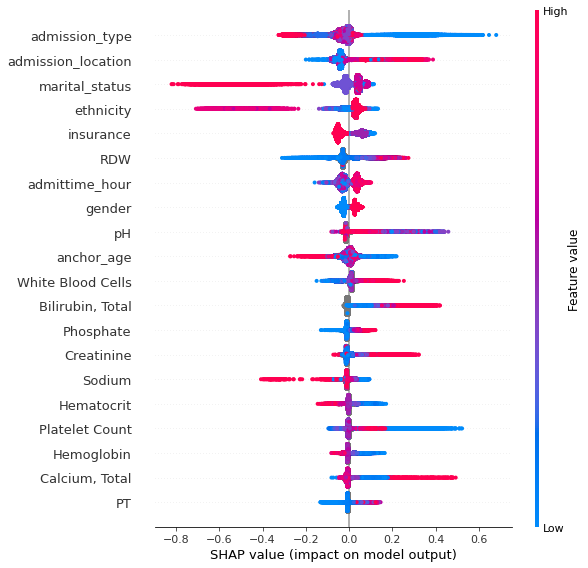

0.6249084847681747 0.62314172054545
start training....
model : XGB
target 7
-------------------
train and test shapes: (135127, 56) (33782, 56)
GPU activated on config, run xgb on GPU...
fold :  0
[0]	train-auc:0.59351	test-auc:0.58278
[100]	train-auc:0.63246	test-auc:0.61198
[200]	train-auc:0.64386	test-auc:0.61579
[300]	train-auc:0.65397	test-auc:0.61679
[400]	train-auc:0.66394	test-auc:0.61725
[446]	train-auc:0.66799	test-auc:0.61678
0.6174232687606533
fold :  1
[0]	train-auc:0.59048	test-auc:0.57398
[100]	train-auc:0.63350	test-auc:0.60232
[200]	train-auc:0.64534	test-auc:0.60589
[300]	train-auc:0.65498	test-auc:0.60677
[400]	train-auc:0.66432	test-auc:0.60742
[491]	train-auc:0.67222	test-auc:0.60708
0.6076494807116037
fold :  2
[0]	train-auc:0.58748	test-auc:0.58100
[100]	train-auc:0.63058	test-auc:0.61096
[200]	train-auc:0.64103	test-auc:0.61791
[300]	train-auc:0.65144	test-auc:0.62085
[400]	train-auc:0.66044	test-auc:0.62203
[500]	train-auc:0.66906	test-auc:0.62270
[600]	train-a

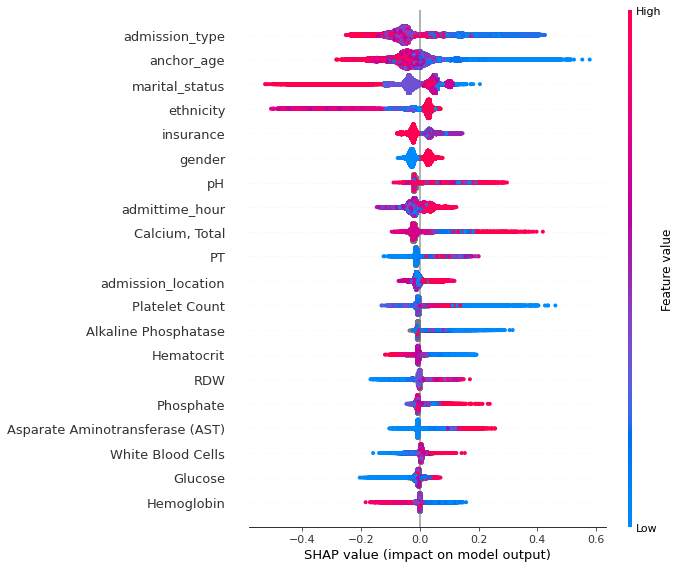

0.6147342521416901 0.6138678163499447


,model,target,ROCAUC,f1_score
0,Logisticregression,30,0.553080,0.231744
1,Logisticregression,7,0.558124,0.129043
2,XGB,30,0.623142,0.267662
3,XGB,7,0.613868,0.110561


In [5]:
if __name__ == "__main__":
    
    config = yaml.safe_load(open("../resources/config.yml"))
    print('Your Config Setting:\n')
    print(config)
    data_dir = config[0]['data_dir'];is_early = config[1]['subtask']['isEarly'];at_discharge = config[1]['subtask']['atDischarge'];at_admission = config[1]['subtask']['atAdmit'];
    er_wt_forrolling = config[2]['wt_forrolling']['erwt_for_rolling']; disch_wt_forrolling = config[2]['wt_forrolling']['dischwt_for_rolling']
    models  =list({k: v for k, v in config[6]['model'].items() if v== 1}.keys())
    targets = list({k: v for k, v in config[7]['target'].items() if v== 1}.keys())
    measures =  list({k: v for k, v in config[8]['measure'].items() if v== 1}.keys())
    
    # If labeled data exists
    if os.path.isdir('erVisits'):
        
        print("\nlabel extraction done before , labeled data exists .Delete ../generate_dataset/erVisits folder if you want to run label extraction module from scratch")
        print("\nReading labeled data  ...")
        frst_vsts = pd.read_pickle('frst_visits.pkl')
        print('\nlabeled data shape , subject_id and hadm_id uniques: ', frst_vsts.shape,frst_vsts.subject_id.nunique(),frst_vsts.hadm_id.nunique())
        frst_vsts = feat_eng_transform(config,frst_vsts )
        #print('uniques: ', frst_vsts.shape,frst_vsts.subject_id.nunique(),frst_vsts.hadm_id.nunique())
        
        if is_early:
            print('\nApply cohort: remove visits with less than 12 hours los')
            vsts_wh = frst_vsts[frst_vsts.visit_los_hrs> 12]
            print('shape,  subject_id and hadm_id uniques , after applying cohorts visit los < 12 hours :', vsts_wh.shape,vsts_wh.subject_id.nunique(),vsts_wh.hadm_id.nunique())
            labeled_data = getfeaturesFromEventsTables(config, vsts_wh)
            
            drps =[ 'discharge_location', 'dischtime_day','dischtime_hour','visitlos', 'visit_los_hrs', 'admittime','dischtime']
            labeled_data.drop(drps, axis=1, inplace=True)
            display('Final data', labeled_data.dtypes)
            print("Outliers Healing...")
            #labeled_data = outlier_heal(config, labeled_data) remove comment and next line if you want to heal outlier with classis IsoForest
            labeled_data = outlier_heal_eif(config, labeled_data) 
            #display(labeled_data.dtypes)
            results = train_models(config, labeled_data, models, targets)
            display(results)
                           
                    
        elif at_discharge:
            print('Apply cohort: remove visits with less than 24 hours los')
            vsts_wh = frst_vsts[frst_vsts.visit_los_hrs> 24]
            print('shape,  subject_id and hadm_id uniques , after applying cohorts visit los < 24 hours :', vsts_wh.shape,vsts_wh.subject_id.nunique(),vsts_wh.hadm_id.nunique())
            labeled_data = getfeaturesFromEventsTables(config, vsts_wh)
            
            drps =drps = ['admittime', 'dischtime','visitlos']
            labeled_data.drop(drps, axis=1, inplace=True)
            display(labeled_data.dtypes)
            print("Outliers Healing...")
            labeled_data.to_pickle('disch_final.pkl')
            #labeled_data = outlier_heal(config, labeled_data)remove comment and next lineif you want to heal outlier with classis IsoForest
            labeled_data = outlier_heal_eif(config, labeled_data)
            results = train_models(config, labeled_data, models, targets)
            print(" ------  Results ------")
            display(results)
              
        else: #atAdmit
        
            labeled_data = frst_vsts.copy()
            drps = ['admittime', 'dischtime', 
                   'discharge_location', 
                   'dischtime_day',
                   'dischtime_hour', 'visitlos', 'visit_los_hrs']
            labeled_data.drop(drps, axis=1, inplace=True)
            display(labeled_data.dtypes)
            
            results = train_models(config, labeled_data, models, targets)
            
            print(" ------  Results ------")
            display(results)
                   
    # Label Extraction(once)
            
    else: 
        
        df_static_table = getfeaturesFromStaticTables(config=config)
        df_static_table = prep_vsts_dts(df_static_table)
        df_static_table = clean_temporals(df_static_table)
        print('shapes after incorrect admittime and dischtime , Uniques, visits, subjects:',df_static_table.hadm_id.unique().shape[0],df_static_table.subject_id.unique().shape[0])
        print('Applying age cohort 18 yo...')
        df_static_table= filter_visit_on_age(df_static_table)
        print('shapes after age cohort , Uniques, visits, subjects:', df_static_table.hadm_id.unique().shape[0],df_static_table.subject_id.unique().shape[0])
        print('Applying admissin type cohort Elective...')
        
        df_static_table = df_static_table[df_static_table.admission_type != 'ELECTIVE']
        print('shapes after admission type cohort , Uniques, visits, subjects:', df_static_table.hadm_id.unique().shape[0],df_static_table.subject_id.unique().shape[0])
        
        print('Breaking stays by subjects ...')
        break_up_visits_by_subject(df_static_table, 'erVisits')
        
        master_visits = label_extraction()
        print('Uniques, visits, subjects:', master_visits.hadm_id.unique().shape[0],master_visits.subject_id.unique().shape[0])
        #master_visits = prep_vsts_dts(master_visits)
        #master_visits.to_pickle(('master_visits.pkl'))
        
        print("Applying cohort getting  first visits by subject...")
        frst_vsts = get_first_visit(master_visits)
        print('Uniques, visits, subjects:',  frst_vsts.hadm_id.unique().shape[0],frst_vsts.subject_id.unique().shape[0])
        
        print("Applying cohort mortality on first visits...")
        frst_vsts = frst_vsts[frst_vsts.MORTALITY_INHOSPITAL ==0]
        #frst_vsts = remove_mortality_visits(frst_vsts)
        del master_visits; gc.collect()
        print('shapes after Applying cohort mortality, Uniques, visits, subjects:', frst_vsts.hadm_id.unique().shape[0],frst_vsts.subject_id.unique().shape[0])
        frst_vsts.to_pickle('frst_visits.pkl') 
